# Notebook to run basic analysis on processed data after cellbender - FPR 0.05, full Model

**Created by :** Srivalli Kolla

**Created on :** 12 August, 2024

**Modified on :** 10 September, 2024

**Institute of SystemsImmunology, University of Würuburg**

Env : scanpy(Python 3.12.4)

# Importing packages

In [1]:
import anndata as ad
import scanpy as sc
import bbknn
import os
import datetime
import numba
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.stats import median_abs_deviation

In [2]:
sc.settings.verbosity = 3
sc.logging.print_versions()
sc.settings.set_figure_params(dpi = 300, color_map = 'RdPu', dpi_save = 300, vector_friendly = True, format = 'svg')

timestamp = datetime.datetime.now().strftime("%d_%m_%y")

-----
anndata     0.10.8
scanpy      1.10.2
-----
PIL                 10.3.0
annoy               NA
asttokens           NA
attr                23.2.0
bbknn               1.6.0
cffi                1.16.0
colorama            0.4.6
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
dateutil            2.9.0.post0
debugpy             1.8.2
decorator           5.1.1
defusedxml          0.7.1
distutils           3.12.4
django              5.0.6
executing           2.0.1
h5py                3.11.0
igraph              0.11.5
ipykernel           6.29.5
ipython_genutils    0.2.0
ipywidgets          8.1.3
jedi                0.19.1
joblib              1.4.2
kiwisolver          1.4.5
legacy_api_wrap     NA
leidenalg           0.10.2
llvmlite            0.43.0
louvain             0.8.2
matplotlib          3.8.4
mpl_toolkits        NA
natsort             8.4.0
numba               0.60.0
numexpr             2.10.1
numpy               1.26.4
packaging           24.1
pandas    

# Data importing and PreProcessing

In [3]:
ref = sc.read_h5ad('../../raw_data/raw_anndatas/dmd_merged_filtered_before_cb_annotated_10_09_24.h5ad')
ref

/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 349081 × 32285
    obs: 'sample', 'genotype', 'n_genes_by_counts', 'total_counts', 'total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'pct_counts_ribo', 'n_counts', 'cell_type-broad'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'pct_dropout_by_counts', 'total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'cell_type-broad_colors', 'genotype_colors', 'hvg', 'log1p', 'neighbors', 'pca', 'sample_colors', 'umap'
    obsm: 'X_pca', 'X_umap'
    varm: 'PCs'
    layers: 'counts', 'normalized', 'sqrt_norm'
    obsp: 'connectivities', 'distances'

In [4]:
after_cb  = sc.read_h5ad(f'../../cellbender/0.05_full/merged_cb_0.05_fpr_full_10_09_24.h5ad') 
after_cb

/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 188274 × 32285
    obs: 'sample', 'genotype'

## Quality check

In [5]:
def X_is_raw(after_cb):
    return np.array_equal(after_cb.X.sum(axis=0).astype(int), after_cb.X.sum(axis=0))

is_raw = X_is_raw(after_cb)
print(is_raw)

True


In [6]:
def X_is_raw(adata):
    return np.array_equal(adata.X.sum(axis=0).astype(int), adata.X.sum(axis=0))

is_raw = X_is_raw(ref)
print(is_raw)

False


### Mt, Rb genes

In [7]:
after_cb.var["mt"] = after_cb.var_names.str.startswith("mt-")

after_cb.var["ribo"] = after_cb.var_names.str.startswith(("rps", "rpl"))

In [8]:
ribo_counts = after_cb.var['ribo'].value_counts()

mt_counts = after_cb.var['mt'].value_counts()

print("Counts of Ribosomal (ribo) Genes:")
print("False:", ribo_counts.get(False, 0))
print("True:", ribo_counts.get(True, 0))
print("\nCounts of Mitochondrial (mt) Genes:")
print("False:", mt_counts.get(False, 0))
print("True:", mt_counts.get(True, 0))

Counts of Ribosomal (ribo) Genes:
False: 32285
True: 0

Counts of Mitochondrial (mt) Genes:
False: 32272
True: 13


### QC metrics calculation

In [9]:
sc.pp.calculate_qc_metrics(
    after_cb, qc_vars=["mt", "ribo"], inplace=True, percent_top=[20],log1p=True)
after_cb

AnnData object with n_obs × n_vars = 188274 × 32285
    obs: 'sample', 'genotype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

### Visualization of data cutoff determination

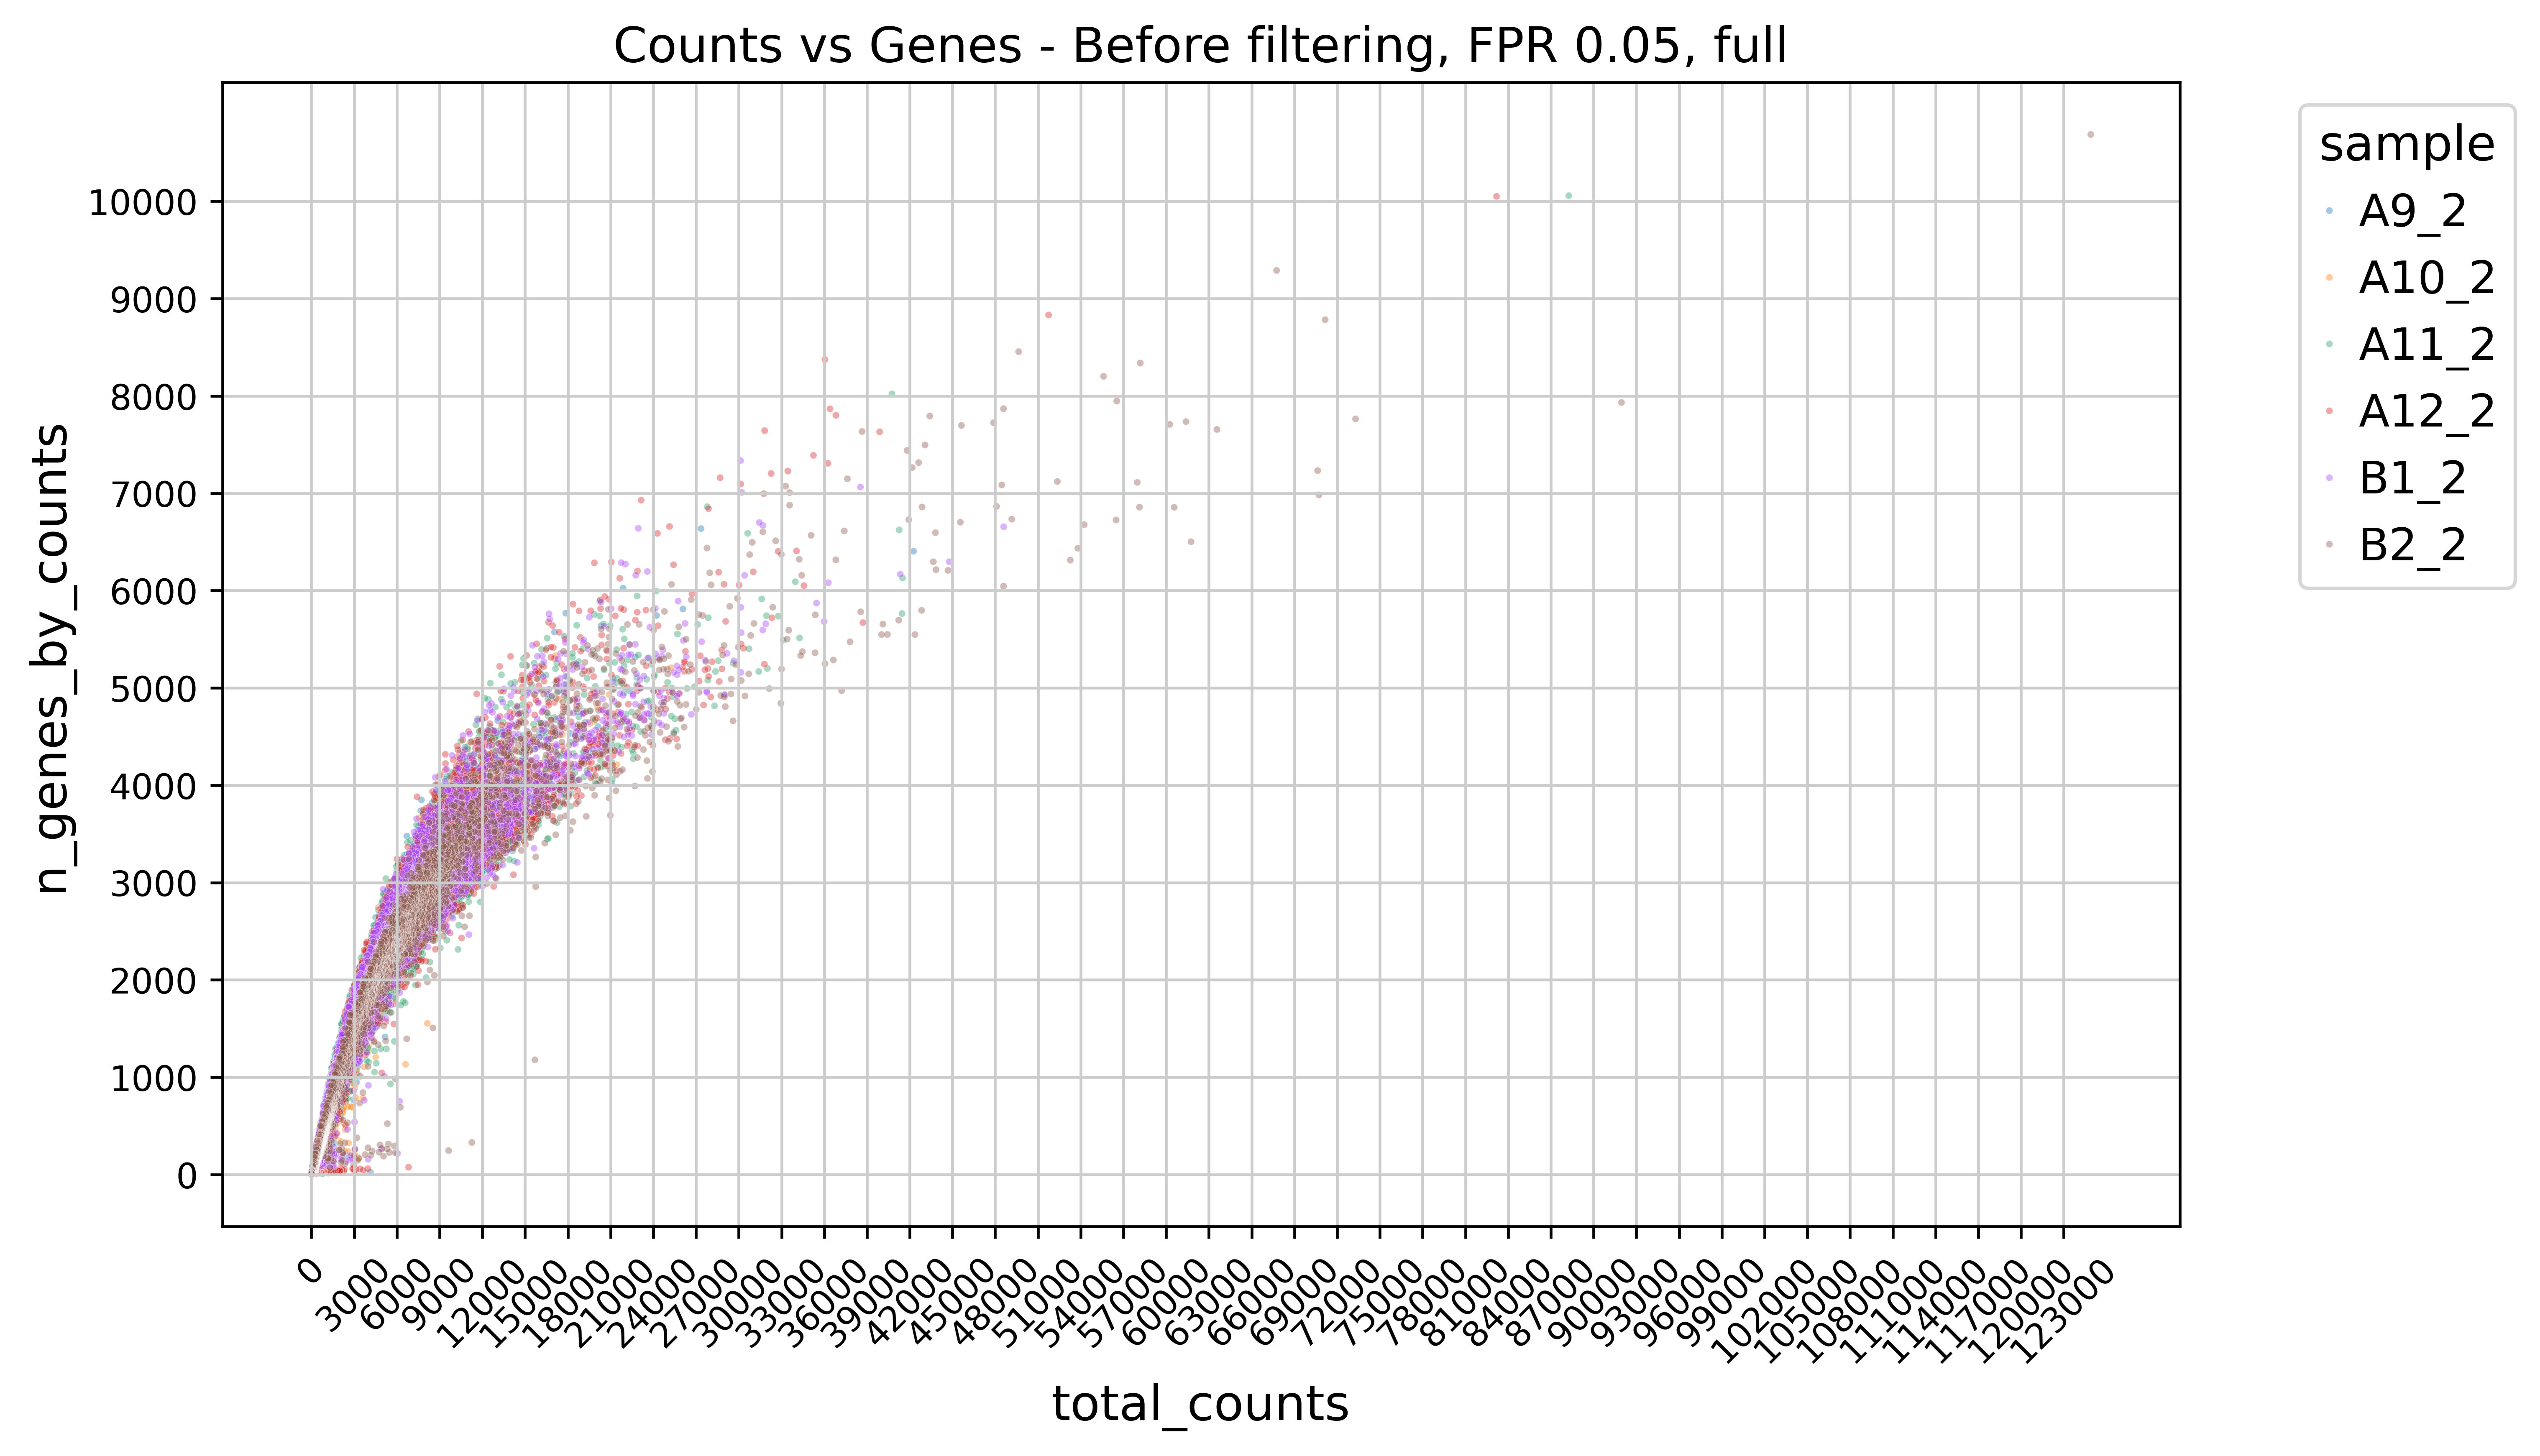

In [10]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=after_cb.obs, x='total_counts', y='n_genes_by_counts' , hue ='sample', alpha = 0.4, s=4)
plt.legend(title='sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(0, int(max(after_cb.obs['total_counts'])) + 1, 3000),rotation=45, fontsize = 10)
plt.yticks(range(0, int(max(after_cb.obs['n_genes_by_counts'])) + 1, 1000),fontsize = 10)
plt.title(f'Counts vs Genes - Before filtering, FPR 0.05, full')
plt.show()

Text(0.5, 1.0, 'Mt and Ribo percentages - Before filtering, FPR 0.05, full')

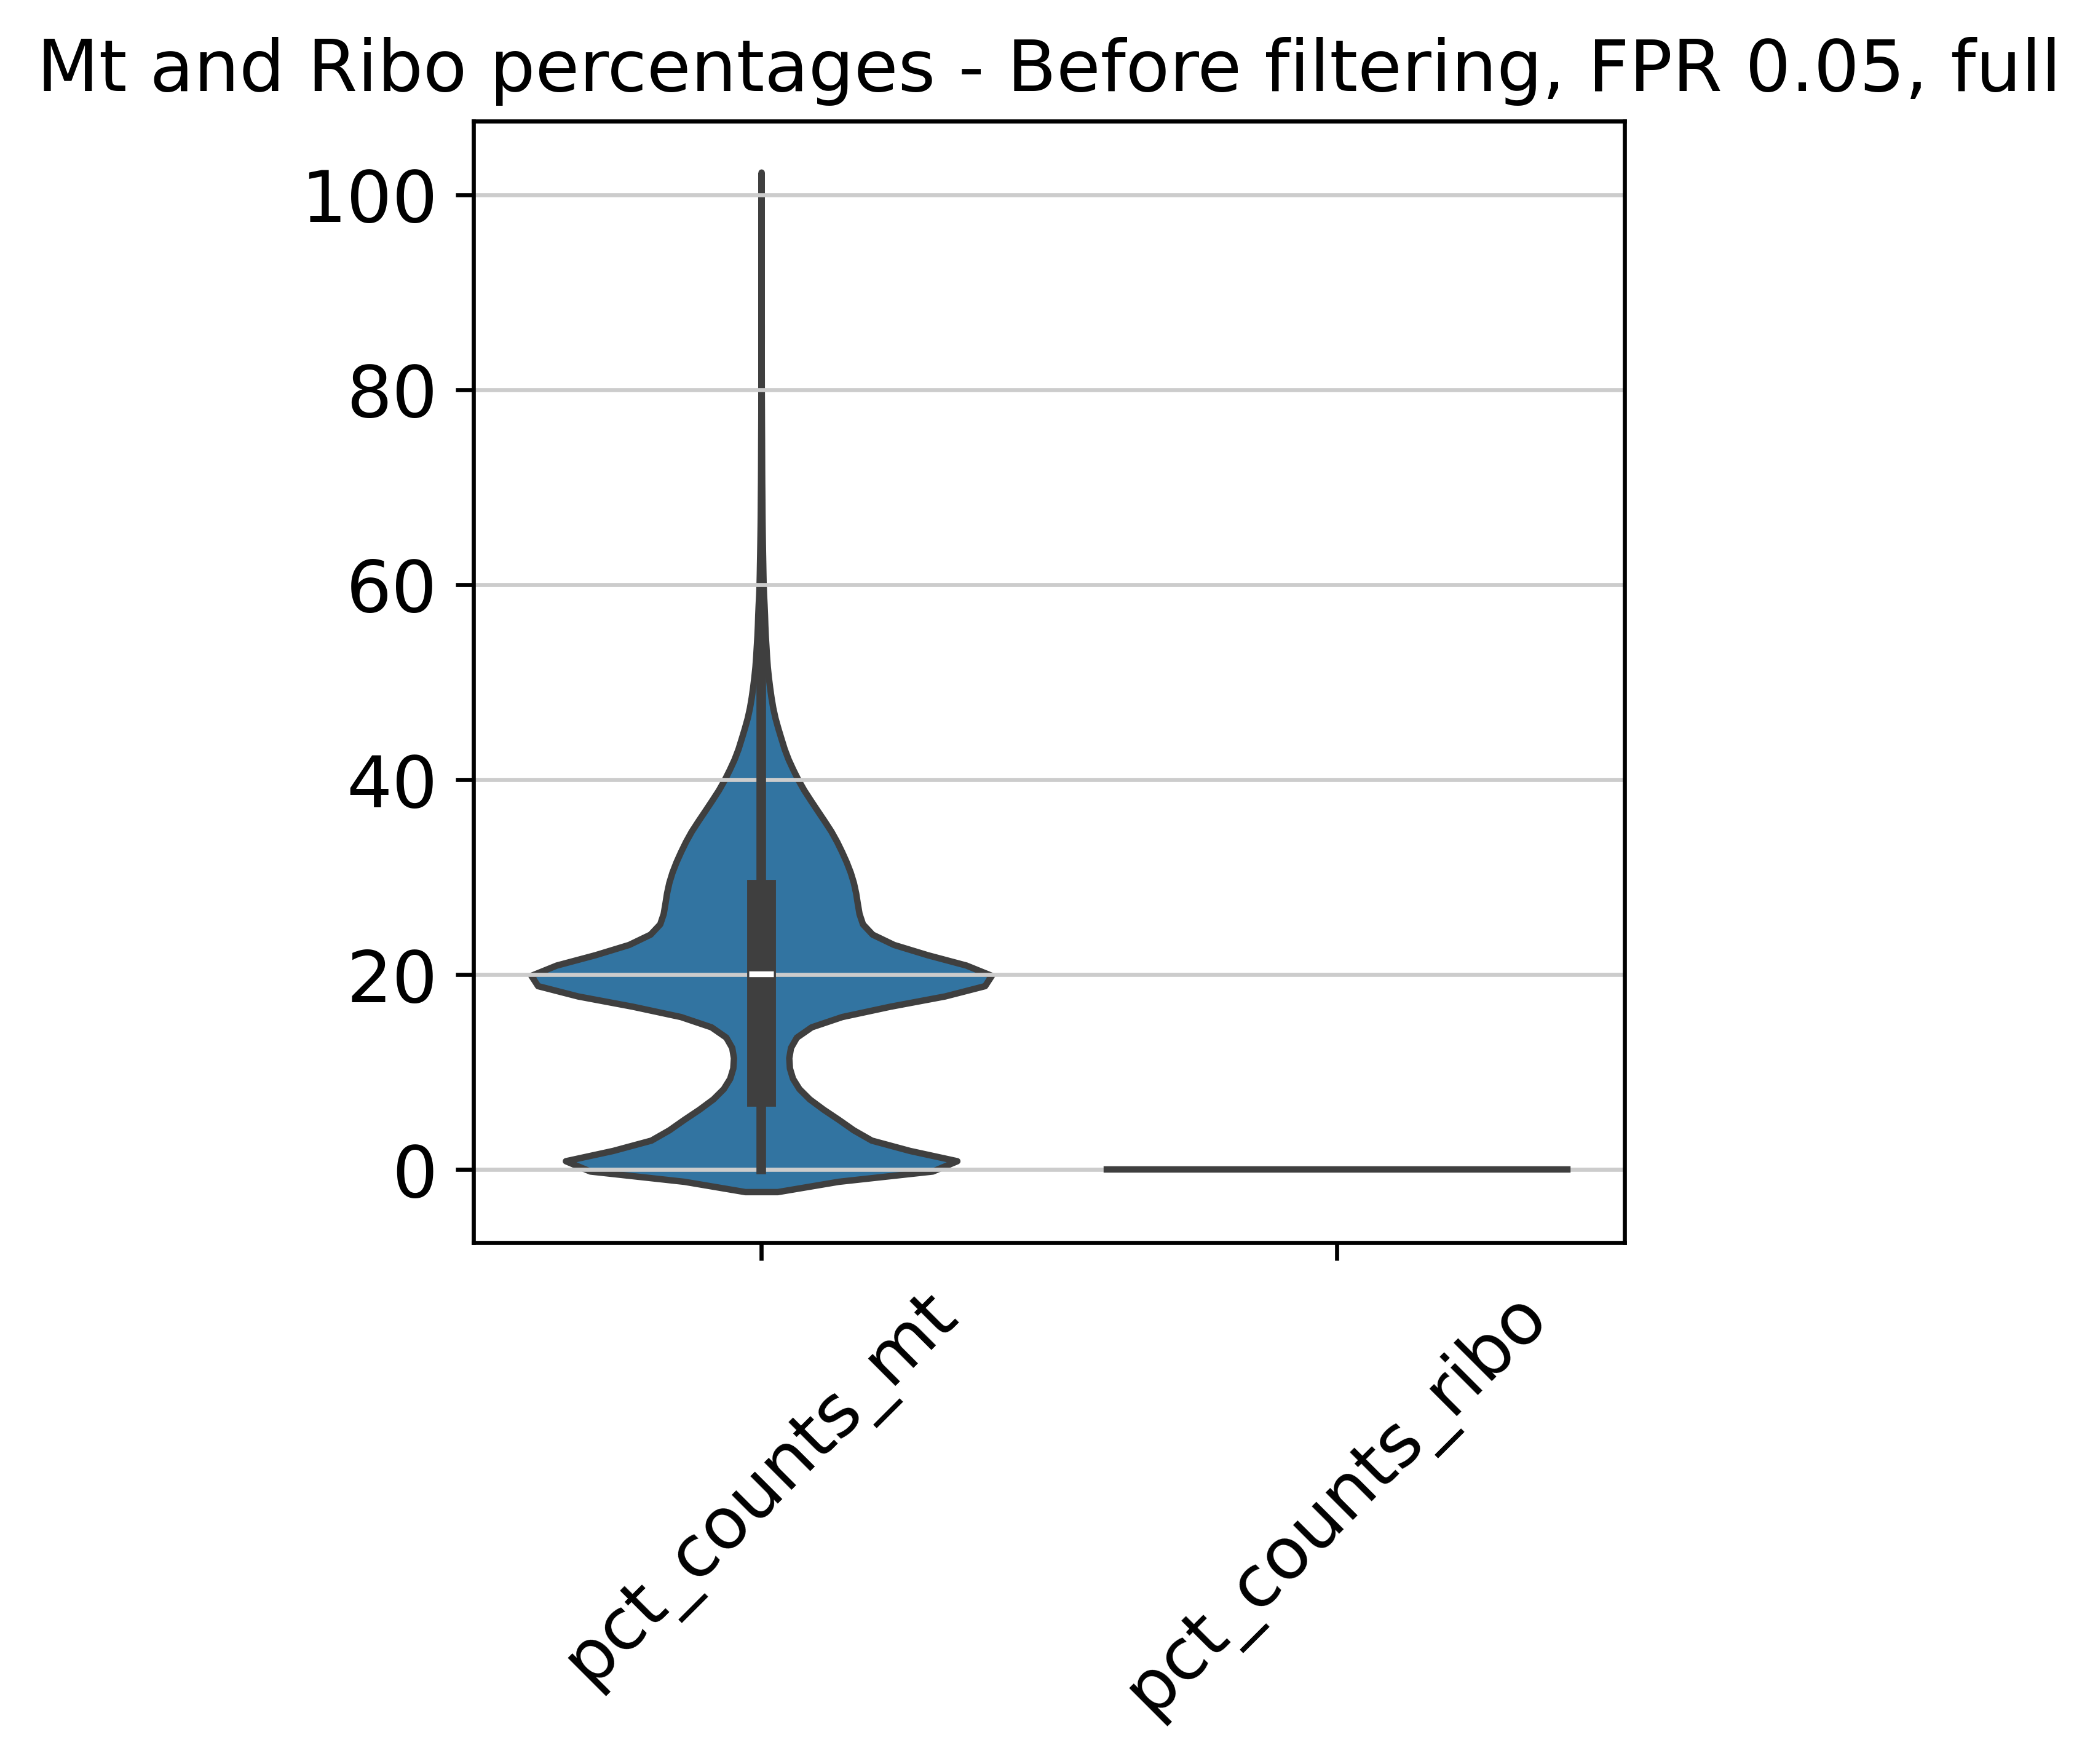

In [11]:
variables = ['pct_counts_mt', 'pct_counts_ribo']

sns.violinplot(data=after_cb.obs[variables])
plt.xticks(rotation=45)
plt.title(f'Mt and Ribo percentages - Before filtering, FPR 0.05, full')

### Filtration

In [12]:
filtered_object = after_cb[after_cb.obs['n_genes_by_counts'] > 200]
filtered_object = filtered_object[filtered_object.obs['n_genes_by_counts'] < 6000]

filtered_object = filtered_object[filtered_object.obs['total_counts'] > 200]
filtered_object = filtered_object[filtered_object.obs['total_counts'] < 18000]

filtered_object = filtered_object[filtered_object.obs['pct_counts_mt'] < 30]
filtered_object = filtered_object[filtered_object.obs['pct_counts_ribo'] < 20]


filtered_object

View of AnnData object with n_obs × n_vars = 135334 × 32285
    obs: 'sample', 'genotype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

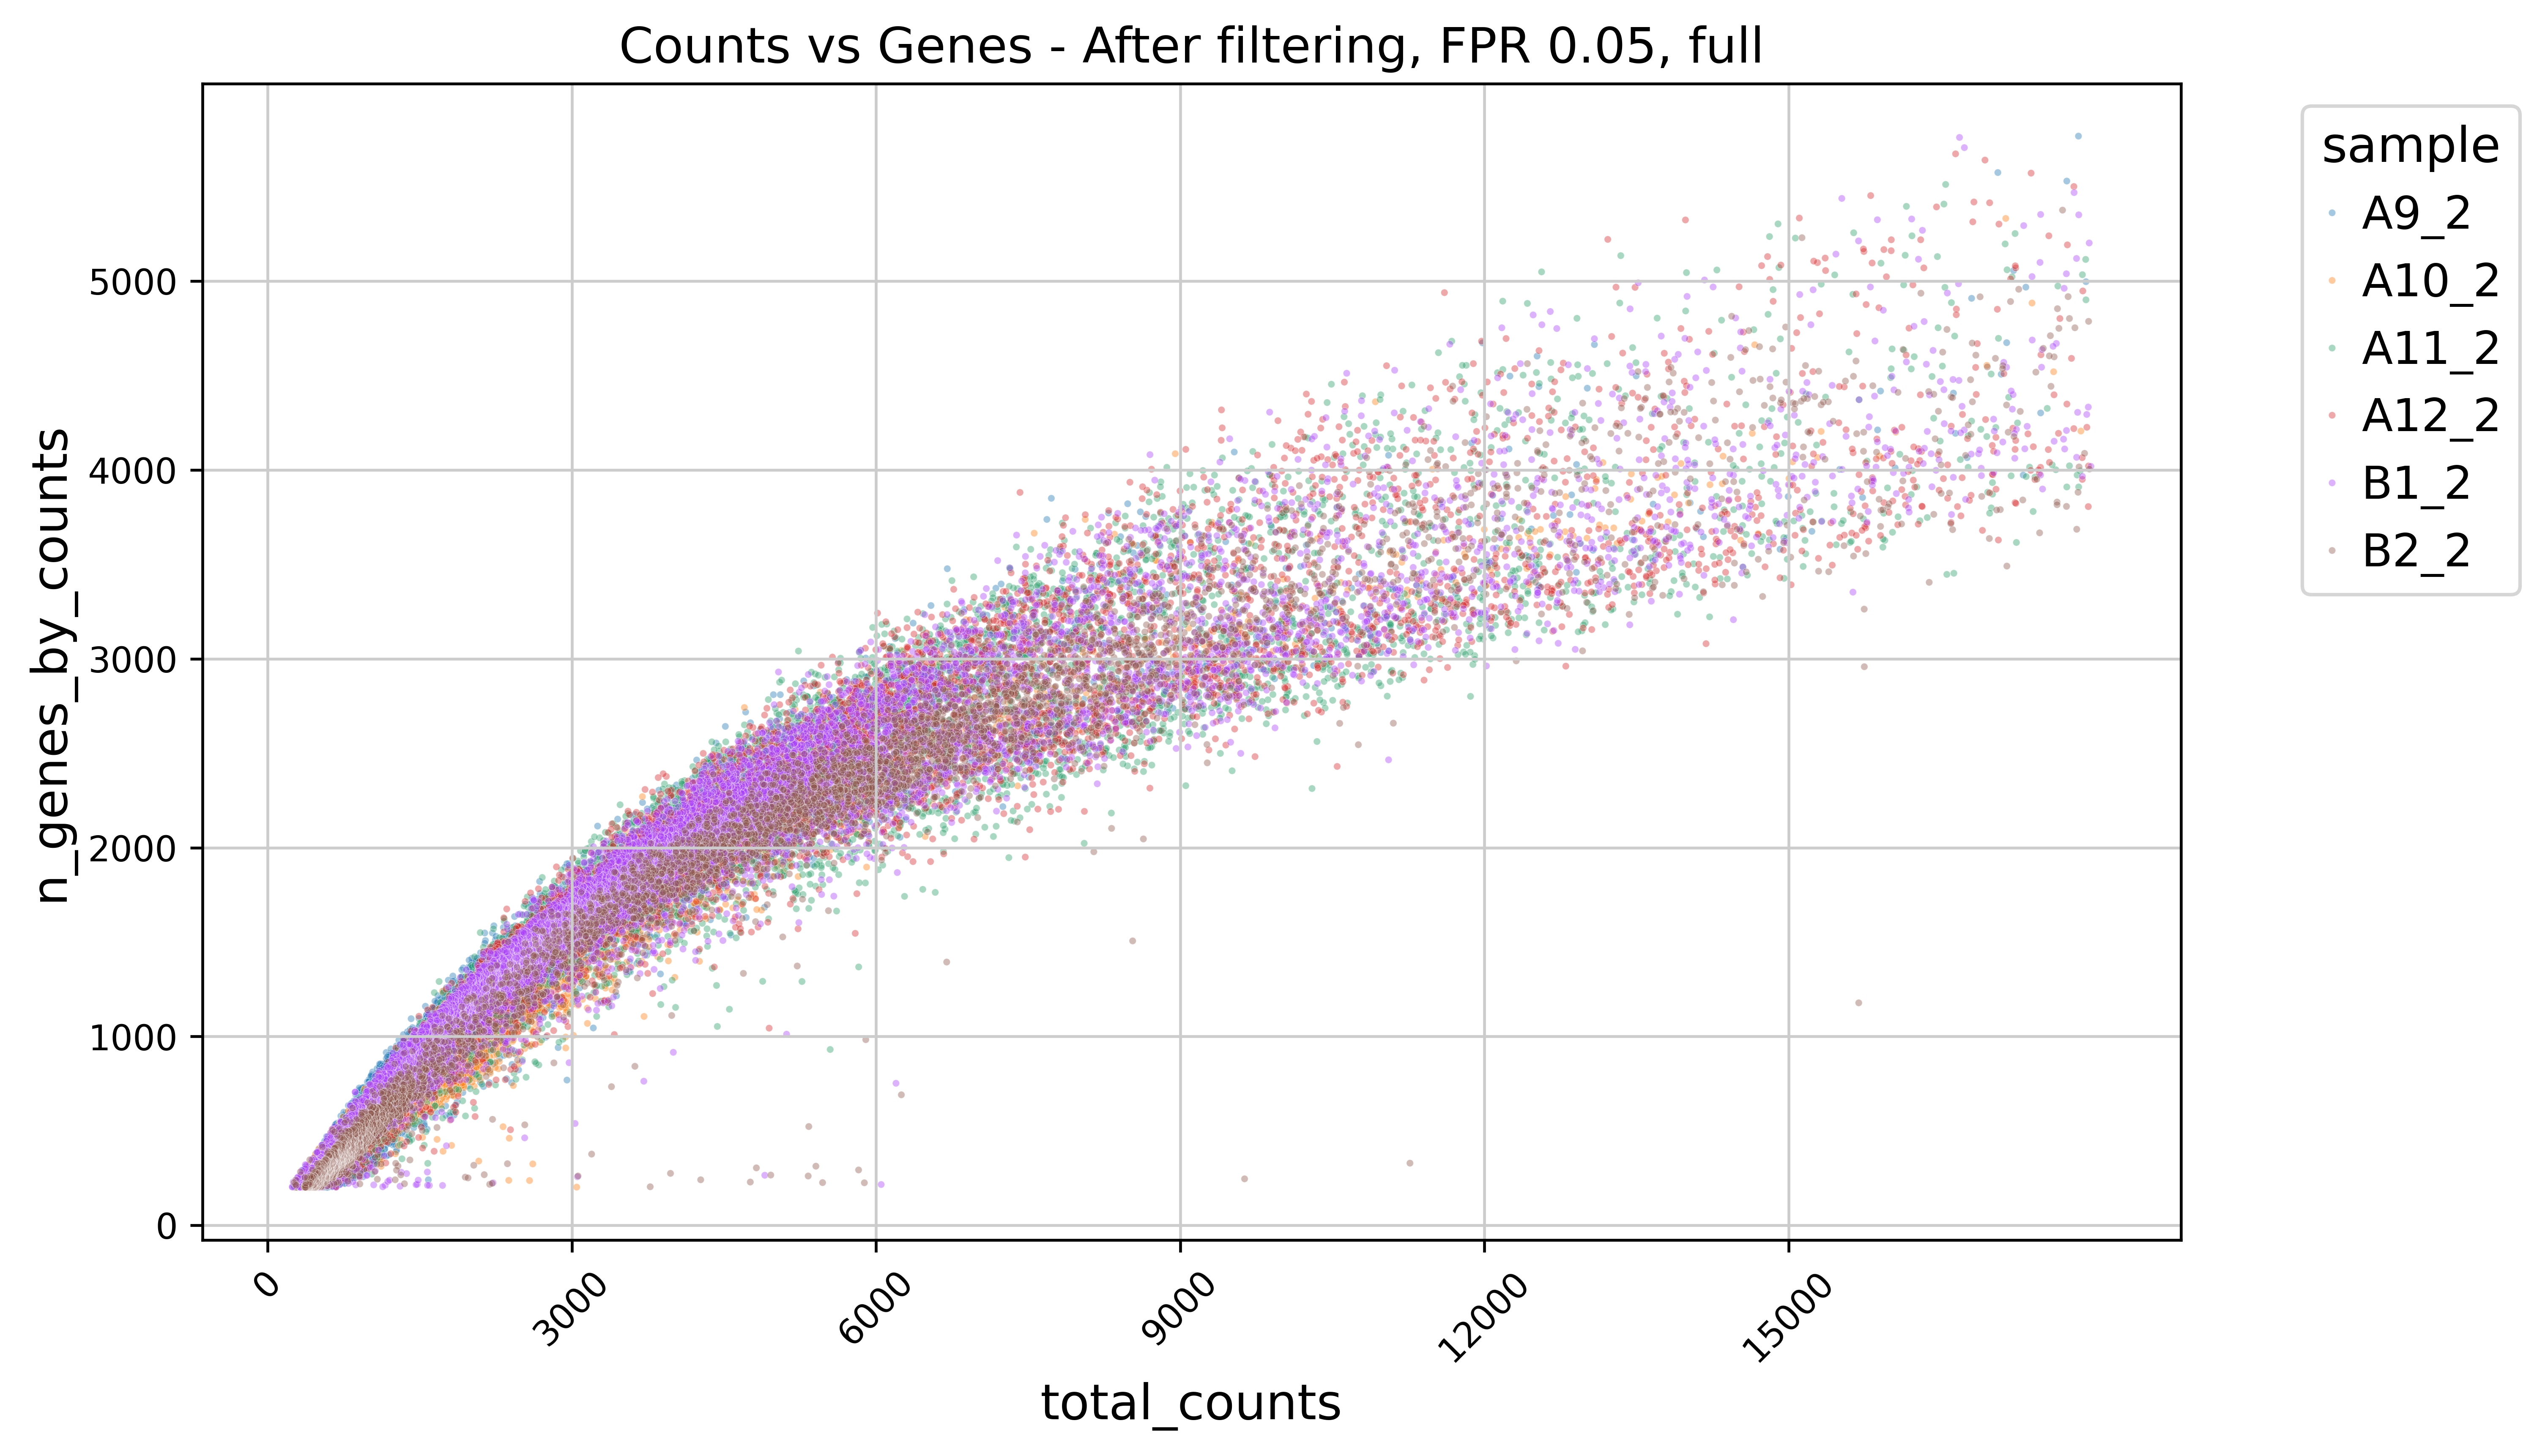

In [13]:
plt.figure(figsize=(10, 6))
sns.scatterplot(data=filtered_object.obs, x='total_counts', y='n_genes_by_counts' , hue ='sample', alpha = 0.4, s=4)
plt.legend(title='sample', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(range(0, int(max(filtered_object.obs['total_counts'])) + 1, 3000),rotation=45, fontsize = 10)
plt.yticks(range(0, int(max(filtered_object.obs['n_genes_by_counts'])) + 1, 1000),fontsize = 10)
plt.title(f'Counts vs Genes - After filtering, FPR 0.05, full')
plt.show()

Text(0.5, 1.0, 'Mt and Ribo percentages - After filtering, FPR 0.05, full')

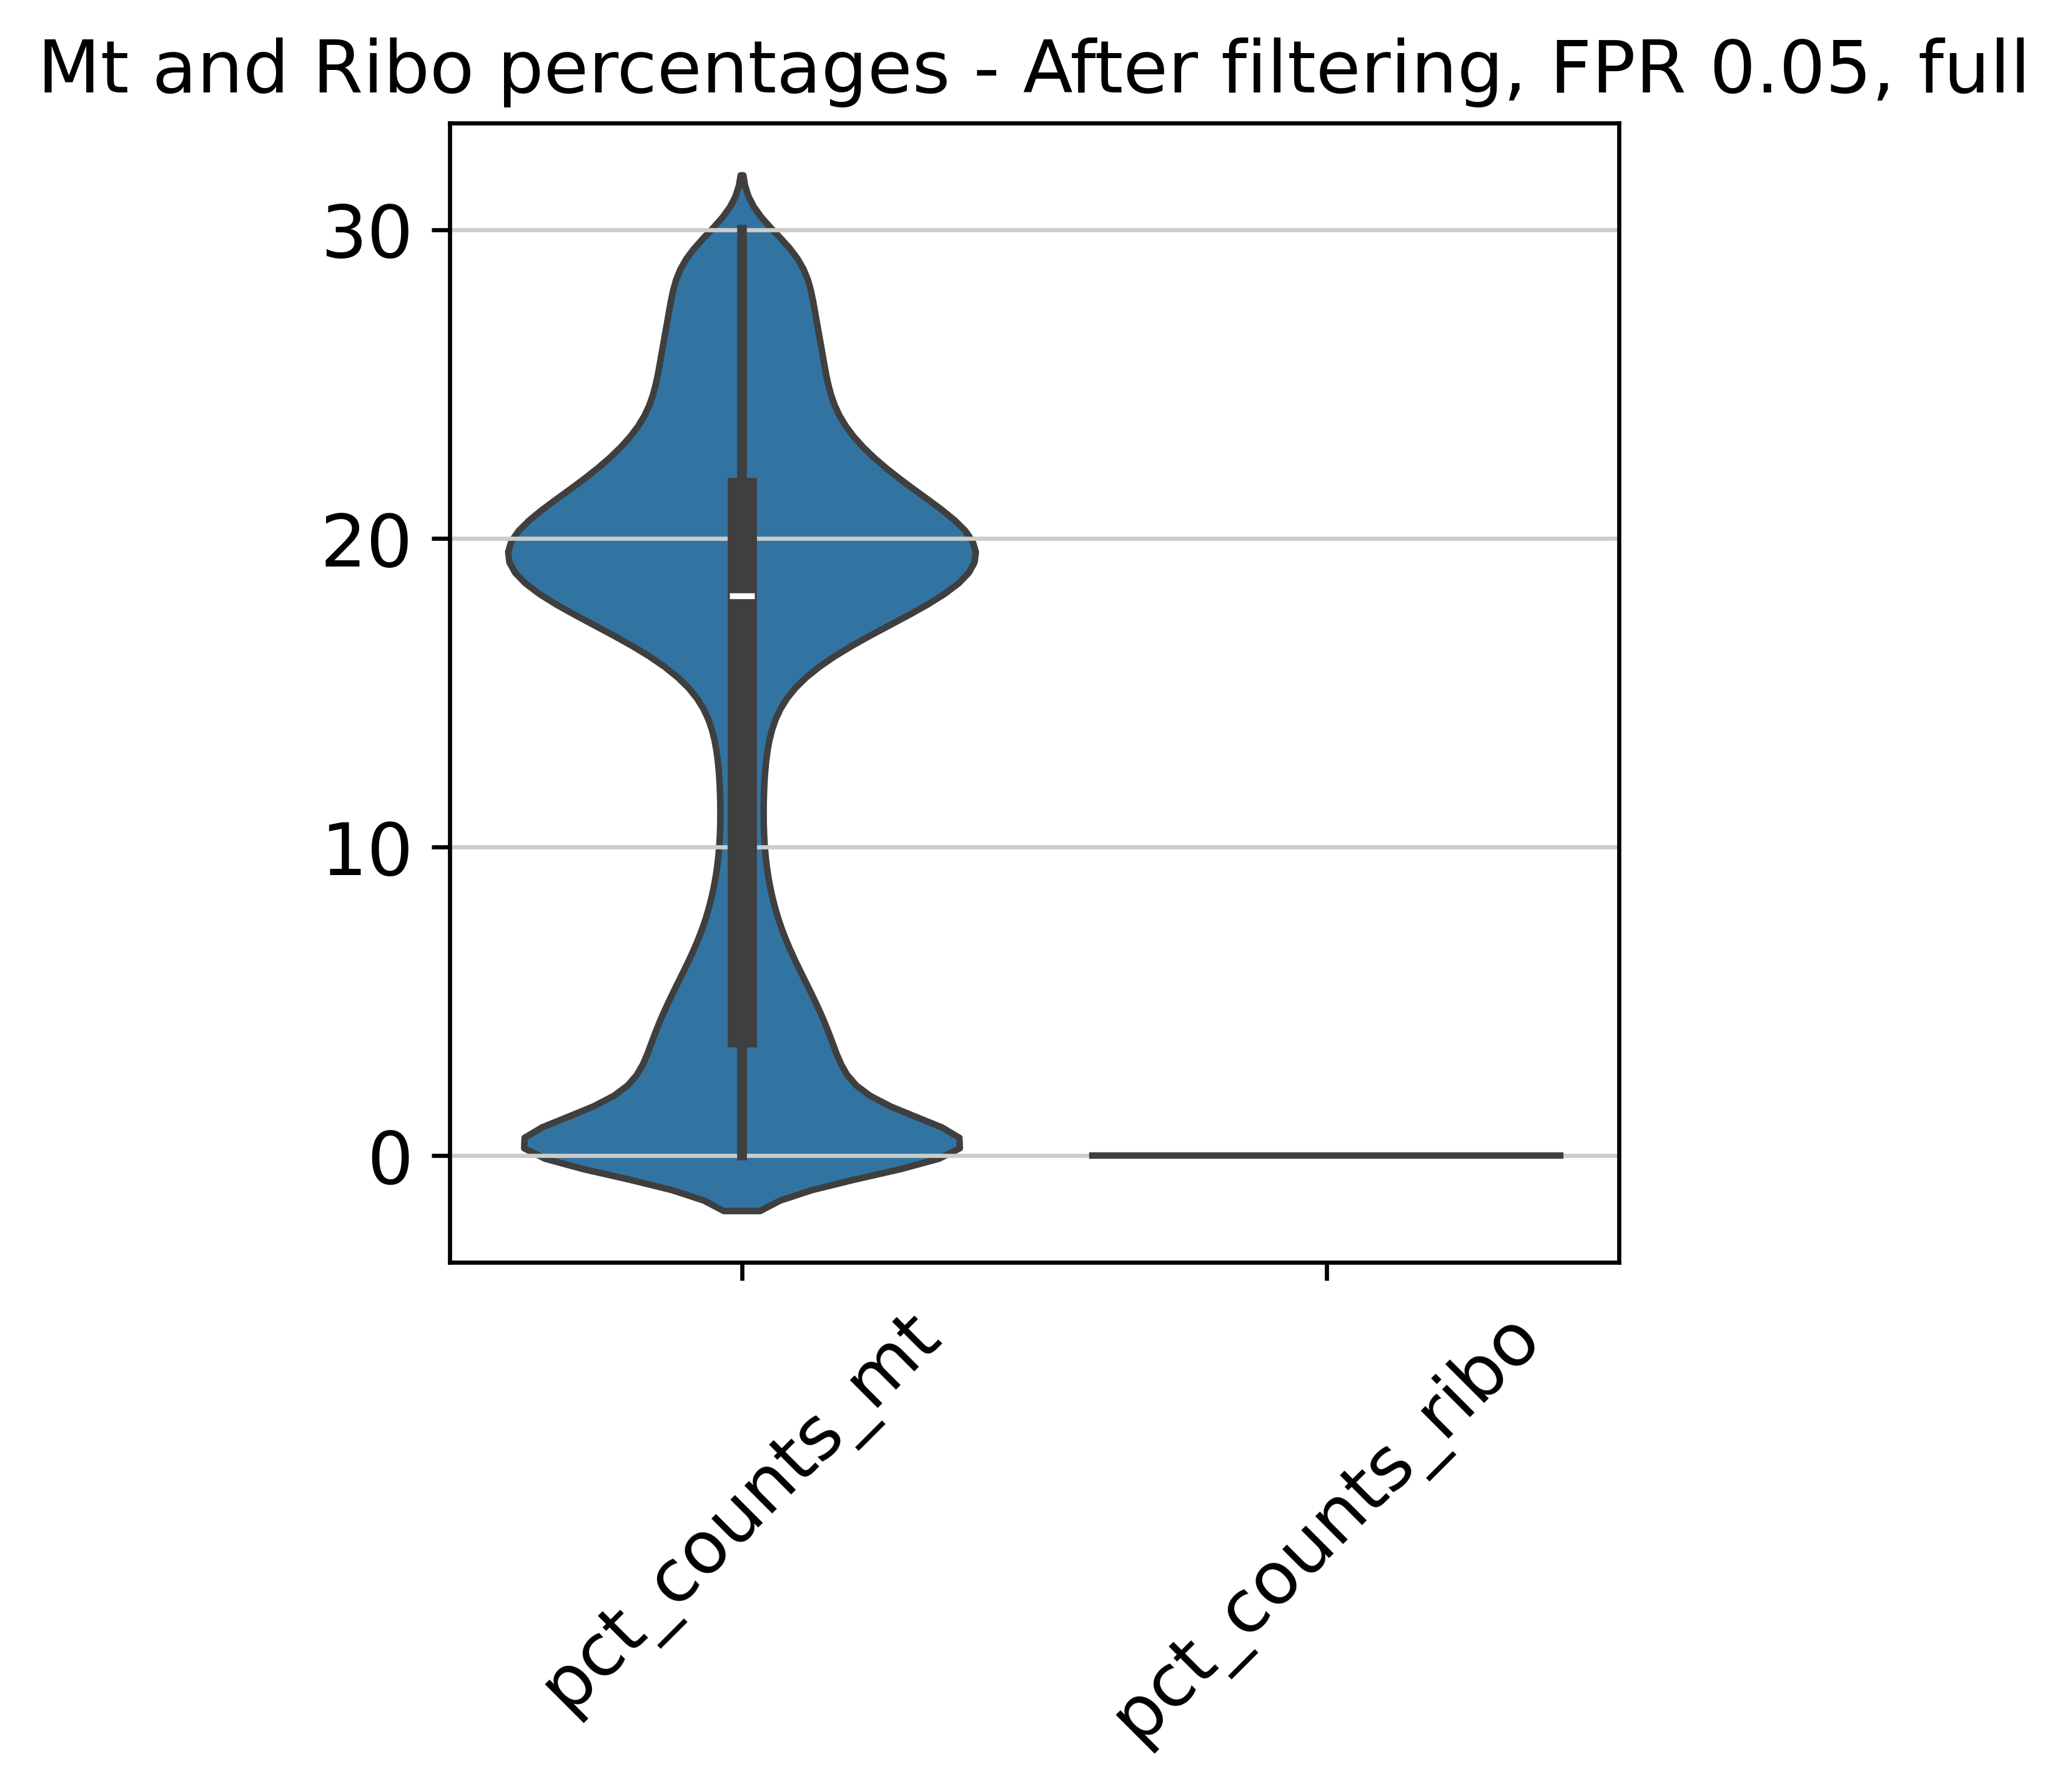

In [14]:
variables = ['pct_counts_mt', 'pct_counts_ribo']

sns.violinplot(data=filtered_object.obs[variables])
plt.xticks(rotation=45)
plt.title(f'Mt and Ribo percentages - After filtering, FPR 0.05, full')

### HVG

In [15]:
sc.pp.highly_variable_genes(filtered_object,flavor = "seurat_v3",batch_key= 'sample')
filtered_object

extracting highly variable genes


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_highly_variable_genes.py:172: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


--> added
    'highly_variable', boolean vector (adata.var)
    'highly_variable_rank', float vector (adata.var)
    'means', float vector (adata.var)
    'variances', float vector (adata.var)
    'variances_norm', float vector (adata.var)


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


AnnData object with n_obs × n_vars = 135334 × 32285
    obs: 'sample', 'genotype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg'

### Normalization

In [16]:
sc.pp.normalize_total(filtered_object, target_sum= 1e6)
sc.pp.log1p(filtered_object)
filtered_object.layers["normalized"] = filtered_object.X.copy()

normalizing counts per cell
    finished (0:00:00)


### Visualization of Gene Expression of Genes from Empty droplets

1. Define list of genes from empty droplets
2. Select genes which are present in my data
3. Filter the data based on the genes present
4. Calculate mean expression of genes adn convert to dataframe
5. plot the values

/tmp/ipykernel_323999/133489725.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Gene', y='Mean Expression', data=gene_mean_expression_df, palette='viridis')


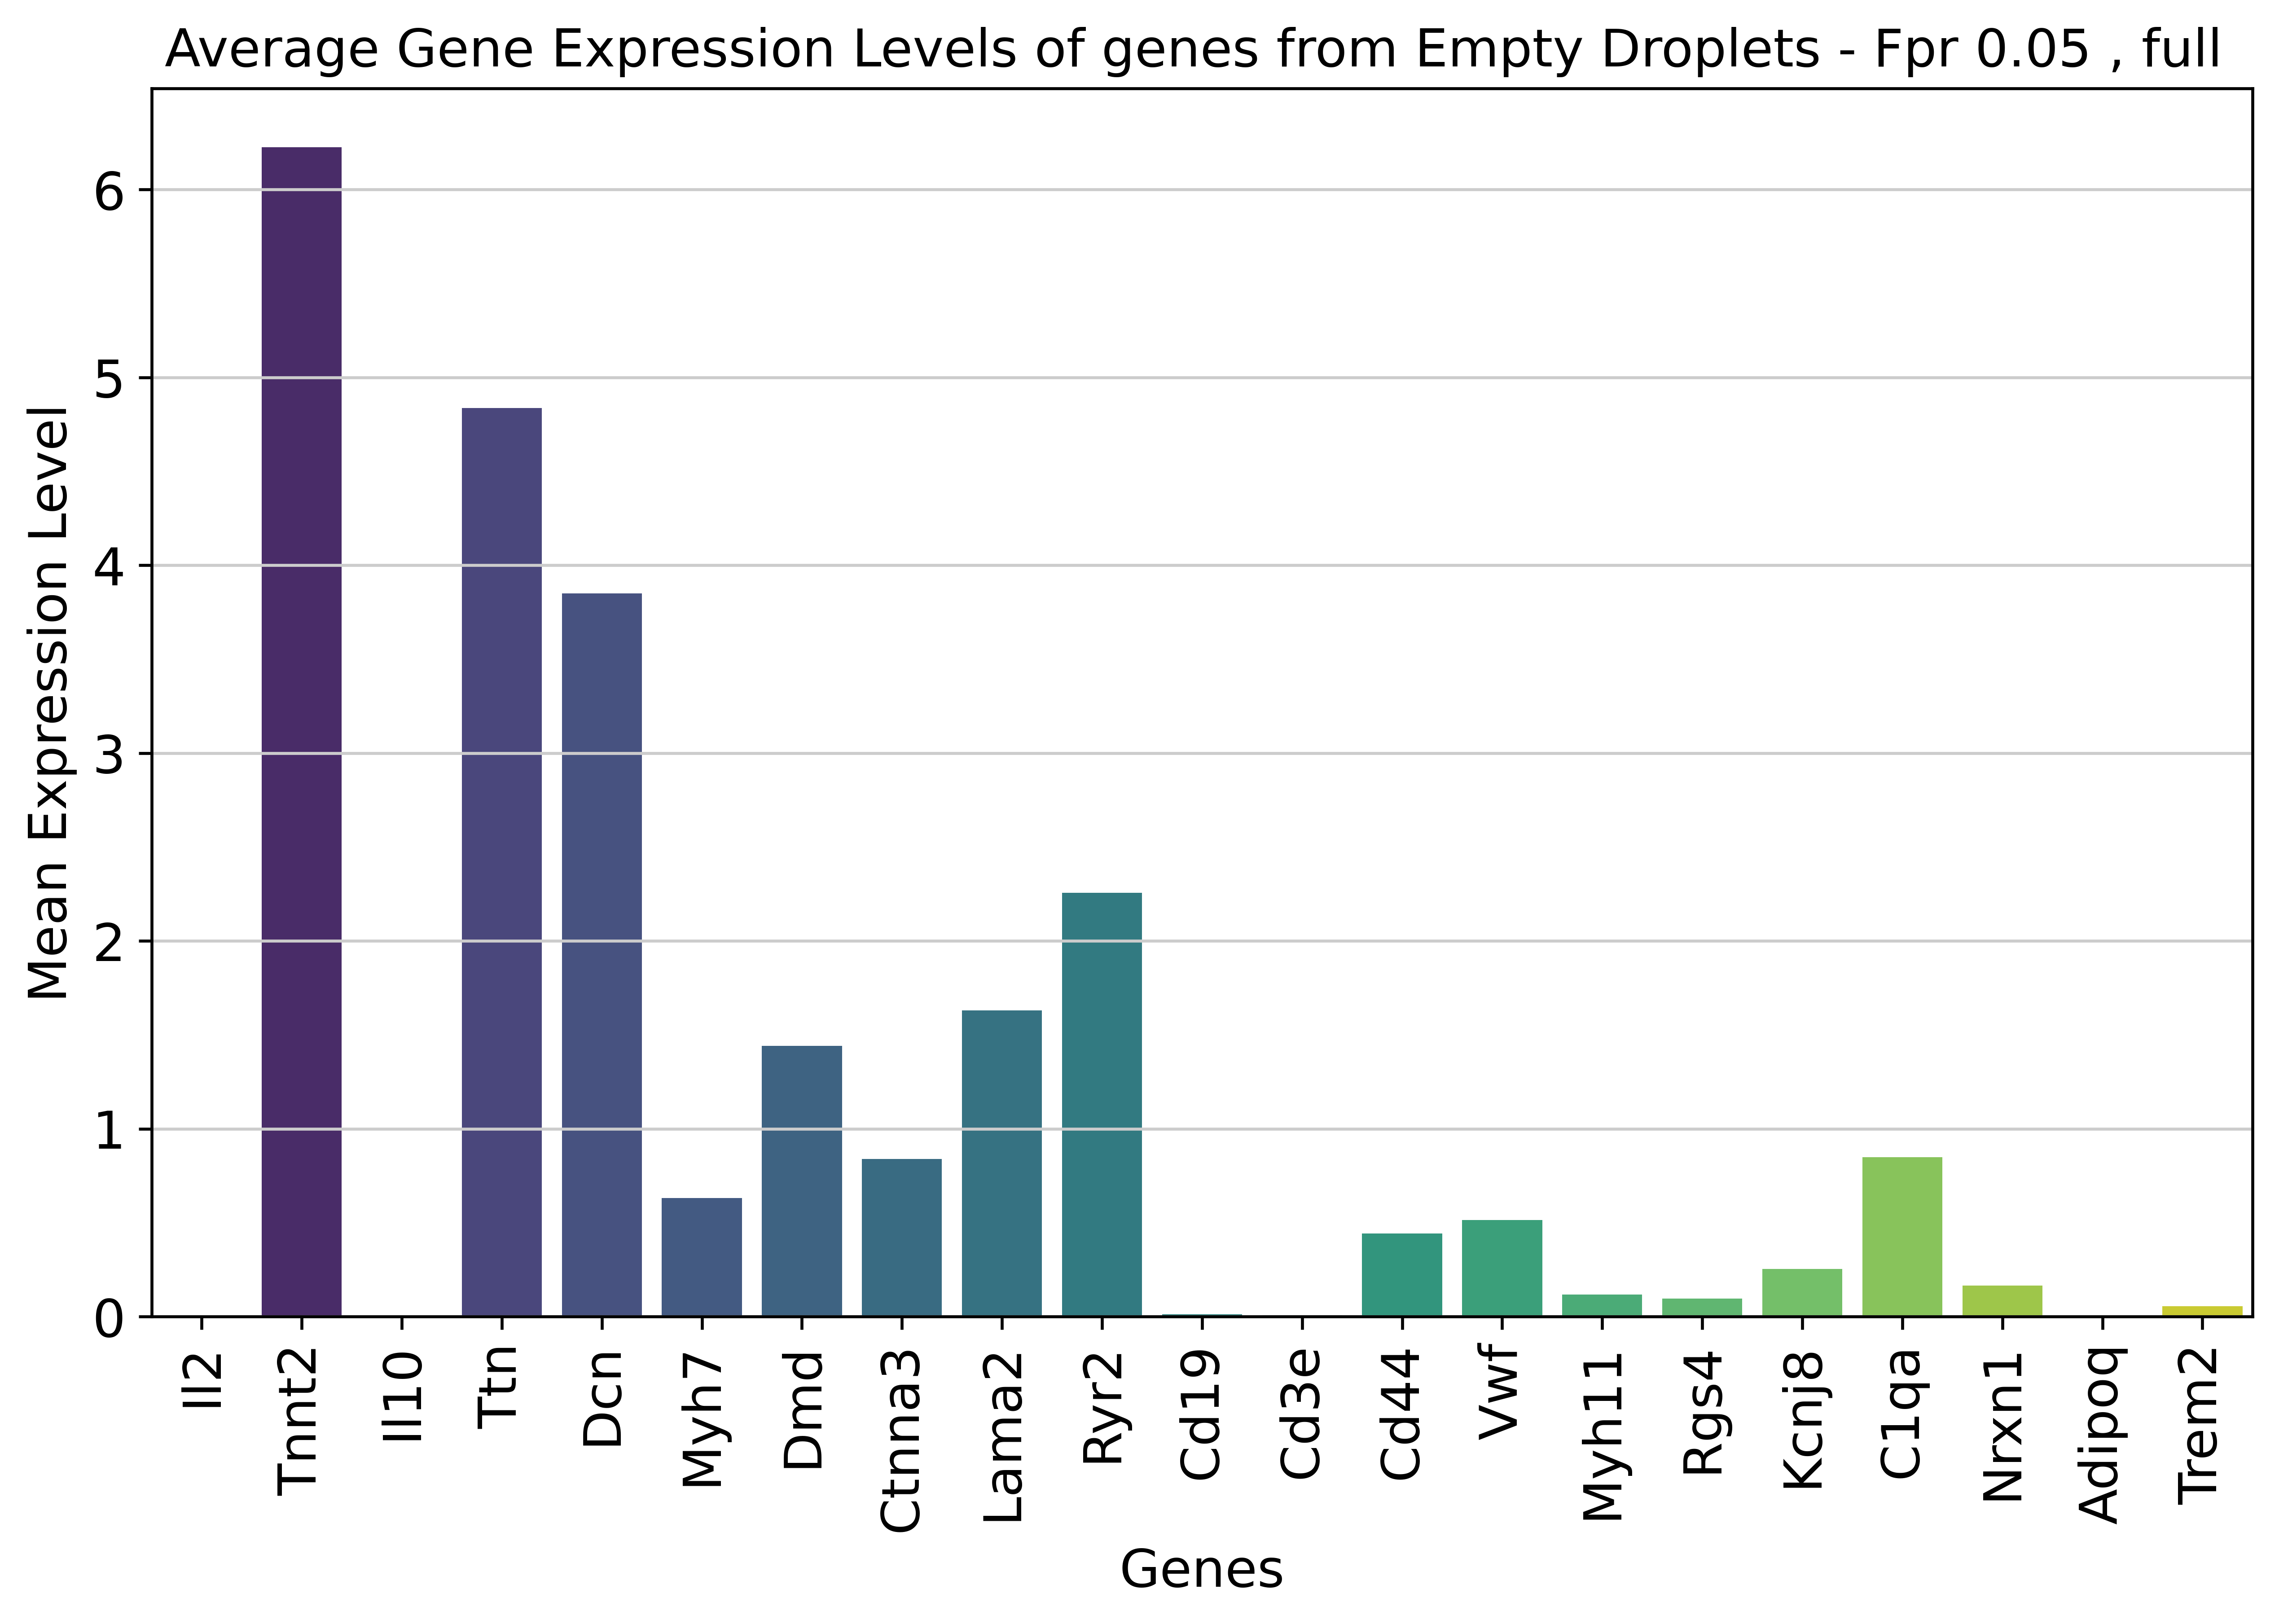

In [17]:
genes_of_interest = ['Il2','Tnnt2','Il10', 'Ttn','Dcn','Myh7', 'Dmd','Ctnna3','Lama2','Ryr2','Cd19','Cd3e','Cd44', 'Vwf', 'Myh11', 'Rgs4', 'Kcnj8', 'C1qa', 'Nrxn1', 'Adipoq', 'Trem2']
present_empty_genes = [gene for gene in genes_of_interest if gene in filtered_object.var.index]

gene_expression_data = filtered_object[:, present_empty_genes].X
gene_expression_df = pd.DataFrame(gene_expression_data.toarray(), columns=present_empty_genes)

gene_mean_expression = gene_expression_df.mean(axis=0)
gene_mean_expression_df = pd.DataFrame({'Gene': gene_mean_expression.index, 'Mean Expression': gene_mean_expression.values})

plt.figure(figsize=(10, 6))
sns.barplot(x='Gene', y='Mean Expression', data=gene_mean_expression_df, palette='viridis')
plt.xticks(rotation=90)
plt.title('Average Gene Expression Levels of genes from Empty Droplets - Fpr 0.05 , full ')
plt.xlabel('Genes')
plt.ylabel('Mean Expression Level')
plt.show()

### Principal Component Analysis

In [18]:
sc.pp.pca(filtered_object, n_comps = 50, use_highly_variable = True, svd_solver = 'arpack', random_state = 1712)
sc.pp.neighbors(filtered_object, use_rep = "X_pca", n_neighbors = 50, metric = 'minkowski', random_state = 1786)

computing PCA
    with n_comps=50


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/scanpy/preprocessing/_pca.py:385: FutureWarning: Argument `use_highly_variable` is deprecated, consider using the mask argument. Use_highly_variable=True can be called through mask_var="highly_variable". Use_highly_variable=False can be called through mask_var=None
  warn(msg, FutureWarning)


    finished (0:00:05)
computing neighbors
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:58)


### Batch correction

In [19]:
bbknn_donor = bbknn.bbknn(filtered_object, 
    batch_key = "sample", copy = True)
bbknn_donor

computing batch balanced neighbors


/home/skolla/miniforge3/envs/scanpy/lib/python3.12/site-packages/anndata/_core/anndata.py:1818: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


	finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:11)


AnnData object with n_obs × n_vars = 135334 × 32285
    obs: 'sample', 'genotype', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_20_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo'
    var: 'mt', 'ribo', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'highly_variable', 'highly_variable_rank', 'means', 'variances', 'variances_norm', 'highly_variable_nbatches'
    uns: 'hvg', 'log1p', 'pca', 'neighbors'
    obsm: 'X_pca'
    varm: 'PCs'
    layers: 'normalized'
    obsp: 'distances', 'connectivities'

## Label Transfer - Mapping Barcodes

In [20]:
ref.obs.index

Index(['AAACCCAAGAAGGTAG-1', 'AAACCCAAGAGAGTGA-1', 'AAACCCAAGATGGCAC-1',
       'AAACCCAAGCACGTCC-1', 'AAACCCAAGCCTAACT-1', 'AAACCCAAGCCTCGTG-1',
       'AAACCCAAGGAATGTT-1', 'AAACCCAAGGCCATAG-1', 'AAACCCAAGGCCGCTT-1',
       'AAACCCAAGGGCAGTT-1',
       ...
       'TTTGTTGGTGGCCTCA-1', 'TTTGTTGGTGTCCCTT-1', 'TTTGTTGGTTGGTACT-1',
       'TTTGTTGTCATTTGTC-1', 'TTTGTTGTCCGACAGC-1', 'TTTGTTGTCCTACACC-1',
       'TTTGTTGTCCTACCGT-1', 'TTTGTTGTCGCTGTCT-1', 'TTTGTTGTCTCGCCTA-1',
       'TTTGTTGTCTCTCTTC-1'],
      dtype='object', length=349081)

In [21]:
bbknn_donor.obs.index

Index(['CTCAACCAGATCCAAA-1', 'TCAGTGATCCTAAACG-1', 'CGGCAGTGTGGCCTCA-1',
       'GGATCTACACATTCGA-1', 'CCTTCAGGTCCTTGTC-1', 'GAAGGACCAGCAGACA-1',
       'TATCGCCAGCATTTGC-1', 'TCGCTCACAAGACCTT-1', 'CACCAAAAGCACTAAA-1',
       'TTTGGAGCACCAGGTC-1',
       ...
       'CACGGGTTCTTGAGCA-1', 'TCAGGTAAGTGGAAAG-1', 'TAAGCGTGTAGTCACT-1',
       'TTGCGTCGTGAGCCAA-1', 'CATTGTTAGTCTACCA-1', 'TCAGTTTAGGGAACAA-1',
       'GCAACCGTCTAACGCA-1', 'AGAGAGCGTCGCAGTC-1', 'GTCAAACCATTGACAC-1',
       'GATTTCTTCGCAGTGC-1'],
      dtype='object', length=135334)

In [22]:
ref_barcodes = pd.DataFrame(ref.obs.index, columns= ['barcodes'])
ref_barcodes

barcodes
0       AAACCCAAGAAGGTAG-1
1       AAACCCAAGAGAGTGA-1
2       AAACCCAAGATGGCAC-1
3       AAACCCAAGCACGTCC-1
4       AAACCCAAGCCTAACT-1
...                    ...
349076  TTTGTTGTCCTACACC-1
349077  TTTGTTGTCCTACCGT-1
349078  TTTGTTGTCGCTGTCT-1
349079  TTTGTTGTCTCGCCTA-1
349080  TTTGTTGTCTCTCTTC-1

[349081 rows x 1 columns]

In [23]:
ref_barcodes['cell_type-broad'] = ref.obs['cell_type-broad'].values
ref_barcodes

barcodes cell_type-broad
0       AAACCCAAGAAGGTAG-1  cardiomyocytes
1       AAACCCAAGAGAGTGA-1  cardiomyocytes
2       AAACCCAAGATGGCAC-1  cardiomyocytes
3       AAACCCAAGCACGTCC-1  cardiomyocytes
4       AAACCCAAGCCTAACT-1  cardiomyocytes
...                    ...             ...
349076  TTTGTTGTCCTACACC-1             NaN
349077  TTTGTTGTCCTACCGT-1             NaN
349078  TTTGTTGTCGCTGTCT-1             NaN
349079  TTTGTTGTCTCGCCTA-1             NaN
349080  TTTGTTGTCTCTCTTC-1             NaN

[349081 rows x 2 columns]

In [24]:
bbknn_donor_barcodes = pd.DataFrame(filtered_object.obs.index, columns= ['barcodes'])
bbknn_donor_barcodes

barcodes
0       CTCAACCAGATCCAAA-1
1       TCAGTGATCCTAAACG-1
2       CGGCAGTGTGGCCTCA-1
3       GGATCTACACATTCGA-1
4       CCTTCAGGTCCTTGTC-1
...                    ...
135329  TCAGTTTAGGGAACAA-1
135330  GCAACCGTCTAACGCA-1
135331  AGAGAGCGTCGCAGTC-1
135332  GTCAAACCATTGACAC-1
135333  GATTTCTTCGCAGTGC-1

[135334 rows x 1 columns]

In [25]:
mapping_dict = ref_barcodes.set_index('barcodes')['cell_type-broad'].to_dict()
mapping_dict

{'AAACCCAAGAAGGTAG-1': 'cardiomyocytes',
 'AAACCCAAGAGAGTGA-1': 'cardiomyocytes',
 'AAACCCAAGATGGCAC-1': 'cardiomyocytes',
 'AAACCCAAGCACGTCC-1': 'cardiomyocytes',
 'AAACCCAAGCCTAACT-1': 'cardiomyocytes',
 'AAACCCAAGCCTCGTG-1': nan,
 'AAACCCAAGGAATGTT-1': 'cardiomyocytes',
 'AAACCCAAGGCCATAG-1': 'cardiomyocytes',
 'AAACCCAAGGCCGCTT-1': 'cardiomyocytes',
 'AAACCCAAGGGCAGTT-1': 'cardiomyocytes',
 'AAACCCAAGGGCCCTT-1': 'cardiomyocytes',
 'AAACCCAAGGTAGCCA-1': 'cardiomyocytes',
 'AAACCCAAGGTTGGTG-1': 'cardiomyocytes',
 'AAACCCAAGTAACGAT-1': 'cardiomyocytes',
 'AAACCCAAGTACAGCG-1': 'cardiomyocytes',
 'AAACCCAAGTACCATC-1': 'cardiomyocytes',
 'AAACCCAAGTACCCTA-1': 'cardiomyocytes',
 'AAACCCAAGTATGTAG-1': 'cardiomyocytes',
 'AAACCCAAGTCATCGT-1': 'cardiomyocytes',
 'AAACCCAAGTGTGTTC-1': 'cardiomyocytes',
 'AAACCCAAGTGTTCAC-1': 'lymphoid',
 'AAACCCAAGTTAGAAC-1': 'cardiomyocytes',
 'AAACCCAAGTTTCGGT-1': 'cardiomyocytes',
 'AAACCCACAAAGCGTG-1': 'cardiomyocytes',
 'AAACCCACAAATCAAG-1': 'cardiomyocy

In [26]:
bbknn_donor_barcodes['cell_type-broad'] = bbknn_donor_barcodes['barcodes'].map(mapping_dict).fillna('Unmatched')

bbknn_donor.obs['cell_type-broad'] = bbknn_donor_barcodes['cell_type-broad'].values

bbknn_donor.obs['cell_type-broad'].value_counts()

cell_type-broad
Unmatched          93381
myeloid            16739
vascular states    13430
fibroblasts         8543
lymphoid            2830
cardiomyocytes       411
Name: count, dtype: int64

# Data visualization

In [27]:
sc.tl.umap(bbknn_donor)
sc.pl.umap(bbknn_donor, color= ['sample','genotype','cell_type-broad'], frameon =False)

computing UMAP


In [ ]:
genes_of_interest = ['Il2','Tnnt2','Il10', 'Ttn','Dcn','Myh7', 'Dmd','Ctnna3','Lama2','Ryr2','Cd19','Cd3e','Cd44', 'Vwf', 'Myh11', 'Rgs4', 'Kcnj8', 'C1qa', 'Nrxn1', 'Adipoq', 'Trem2']

present_genes = [gene for gene in genes_of_interest if gene in bbknn_donor.var.index]

In [ ]:
sc.pl.umap(bbknn_donor, color = present_genes, frameon = False)

In [ ]:
sc.pl.dotplot(bbknn_donor, var_names= present_empty_genes, groupby= 'sample', cmap= 'RdYlBu_r', title= ' Gene expression of genes found in Empty droplets After Cellbender - FPR 0.05- full')
sc.pl.dotplot(bbknn_donor, var_names= present_empty_genes, groupby= 'cell_type-broad', cmap= 'RdYlBu_r', title= '  Gene expression of genes found in Empty droplets After Cellbender - FPR 0.05- full')
sc.pl.dotplot(bbknn_donor, var_names= present_empty_genes, groupby= 'genotype', cmap= 'RdYlBu_r', title= ' Gene expression of genes found in Empty droplets After Cellbender - FPR 0.05- full')

## LogFC change per Gene

1. Consider the matrix of anndata
2. Calculate mean expression of ref and after cellbender data
3. Calculate logFC
4. Convert logFC to dataframe
5. Make a filtered gene list having genes which are in our given list and plot the bargraph

In [ ]:
ref_log_expr = ref.X
cb_log_expr = bbknn_donor.X

ref_mean_log_expr = np.mean(ref_log_expr,axis=0)
cb_mean_log_expr = np.mean(cb_log_expr,axis=0)

log_fc = ref_mean_log_expr - cb_mean_log_expr 
log_fc = np.asarray(log_fc).flatten()

log_fc_df = pd.DataFrame({'Gene': bbknn_donor.var_names, 'LogFC': log_fc})
log_fc_df


filtered_df = log_fc_df[log_fc_df['Gene'].isin(present_empty_genes)]
filtered_df = filtered_df.sort_values(by='LogFC', ascending=False)

plt.figure(figsize=(12, 8)) 
ax = sns.barplot(x='LogFC', y='Gene', data=filtered_df)
plt.xlabel('Log Fold Change (LogFC)')
plt.ylabel('Gene')
plt.title('Log Fold Change - Fpr 0.05 , full')
for i, v in enumerate(filtered_df['LogFC']):
    ax.text(v, i, f'{v:.2f}', va='center')
plt.tight_layout()
plt.show()

## LogFc per celltype

1. Consider the matrix of anndata and convert to dataframe
2. Calculate mean expression of ref and after cellbender data based on grouping 'cell_type-broad'
3. Find the common genes by doing intersection and seperate those common genes from datasets
4. Calculate mean values and log transform and convert to dataframe
5. Make a filtered gene list having genes which are in our given list and plot the bar graph

In [ ]:
ref_expr_df = ref.to_df()
bbknn_expr_df = bbknn_donor.to_df()

ref_mean_expression = ref_expr_df.groupby(ref.obs['cell_type-broad']).mean()
bbknn_mean_expression = bbknn_expr_df.groupby(bbknn_donor.obs['cell_type-broad']).mean()

common_genes = ref_mean_expression.columns.intersection(bbknn_mean_expression.columns)
ref_mean_expression = ref_mean_expression[common_genes]
bbknn_mean_expression = bbknn_mean_expression[common_genes]


mean_ref_expression = ref_mean_expression.mean(axis=0)

log_fc_df = pd.DataFrame(index=bbknn_mean_expression.index, columns=common_genes)

for gene in common_genes:
    ref_expr = mean_ref_expression[gene]
    log_fc_df[gene] = np.log2((bbknn_mean_expression[gene] + 1) / (ref_expr + 1))  # Adding 1 to avoid log of zero

log_fc_df['Mean LogFC'] = log_fc_df.mean(axis=1)

log_fc_df.reset_index(inplace=True)
log_fc_df.rename(columns={'index': 'cell_type'}, inplace=True)

plt.figure(figsize=(12, 8))
sns.barplot(x='cell_type-broad', y='Mean LogFC', data=log_fc_df)
plt.xticks(rotation=90)
plt.title('Mean Log Fold Change of Cell Types Compared to Average Reference Expression - Fpr 0.05 , full')
plt.xlabel('Cell Type')
plt.ylabel('Mean Log Fold Change (LogFC)')
plt.tight_layout()
plt.show()


## Mean expression of gene per celltype

In [ ]:
gene_expression_data = bbknn_donor[:, present_genes].X
if hasattr(gene_expression_data, 'toarray'):
    gene_expression_data = gene_expression_data.toarray()

gene_expression_df = pd.DataFrame(gene_expression_data, columns=present_genes)
gene_expression_df['cell_type-broad'] = bbknn_donor.obs['cell_type-broad'].values

mean_expression_per_cell_type = gene_expression_df.groupby('cell_type-broad').mean().reset_index()

mean_expression_long = mean_expression_per_cell_type.melt(id_vars='cell_type-broad', var_name='Gene', value_name='Mean Expression')

plt.figure(figsize=(14, 10))
sns.heatmap(mean_expression_per_cell_type.set_index('cell_type-broad').T, cmap='viridis', annot=True, fmt='.2f', linecolor= None, linewidths= 0)
plt.title('Mean Gene Expression per Cell Type - Fpr 0.05 , full')
plt.xlabel('Cell Type')
plt.ylabel('Gene')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()